In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from sklearn import svm
import statsmodels.api as sm

from DLtools.Trial_evaluation_rec import record_list_result,real_eva_error
from DLtools.Data import instant_data,station_sel
from DLtools.feature_sel import call_mar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA

# Load data

In [2]:
loading = instant_data()
df,mode = loading.hourly_instant(),'hour'
#df,mode = loading.daily_instant(),'day'

if mode =='hour': n_past,n_future = 24*7,24
elif mode =='day': n_past,n_future = 30,14
else: n_future=None; print('incorrect input')

st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)
#-----------------------------#
save_path =host_path+'/SVR/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [3]:
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)
    return df

# Handle missing data, clean data

<AxesSubplot:xlabel='date'>

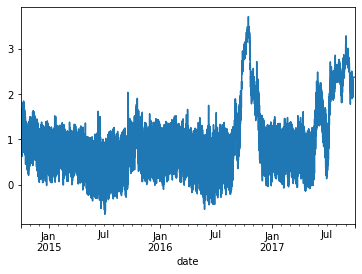

In [3]:
split_date = '2016-11-01'
data = df[start_p:stop_p]
data = data.interpolate(limit=3000000000,limit_direction='both').astype('float32')
data['Day'] = data.index.dayofyear #add day
data[target].plot()

In [5]:
cutoff=.3
data_mar = call_mar(data,target,mode,cutoff=cutoff)
data_mar = move_column_inplace(data_mar,target,0)
n_features = len(data_mar.columns)

# Check stationary

In [19]:
from DLtools.MachineLearning import test_stationarity,tsplot

In [22]:
for col in data_mar.columns:
    #tsplot(data_mar,col)
    test_stationarity(data_mar[col])

Test Statistic             -2.445071
p-value                     0.129417
Lags                       49.000000
Observations            26278.000000
Critical Value (1%)        -3.430599
Critical Value (5%)        -2.861650
Critical Value (10%)       -2.566829
dtype: float64
weak evidence against null hypothesis, time series has a  unit root, indicating it is non-stationary
Test Statistic         -7.304267e+00
p-value                 1.314007e-10
Lags                    4.800000e+01
Observations            2.627900e+04
Critical Value (1%)    -3.430599e+00
Critical Value (5%)    -2.861650e+00
Critical Value (10%)   -2.566829e+00
dtype: float64
strong evidence against the null hypothesis(H0), reject the null hypothesis. Data has no unit root and is stationary
Test Statistic             -3.930294
p-value                     0.001823
Lags                       45.000000
Observations            26282.000000
Critical Value (1%)        -3.430599
Critical Value (5%)        -2.861650
Critical Val

In [28]:
data_diff = data_mar.diff()
data_diff.dropna(inplace=True)

<AxesSubplot:xlabel='date'>

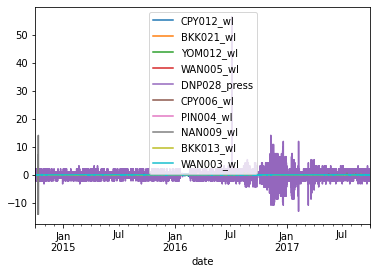

In [25]:
data_diff.plot()

In [26]:
for col in data_mar.columns:
    #tsplot(data_mar,col)
    test_stationarity(data_mar[col])

Test Statistic             -2.445071
p-value                     0.129417
Lags                       49.000000
Observations            26278.000000
Critical Value (1%)        -3.430599
Critical Value (5%)        -2.861650
Critical Value (10%)       -2.566829
dtype: float64
weak evidence against null hypothesis, time series has a  unit root, indicating it is non-stationary
Test Statistic         -7.304267e+00
p-value                 1.314007e-10
Lags                    4.800000e+01
Observations            2.627900e+04
Critical Value (1%)    -3.430599e+00
Critical Value (5%)    -2.861650e+00
Critical Value (10%)   -2.566829e+00
dtype: float64
strong evidence against the null hypothesis(H0), reject the null hypothesis. Data has no unit root and is stationary
Test Statistic             -3.930294
p-value                     0.001823
Lags                       45.000000
Observations            26282.000000
Critical Value (1%)        -3.430599
Critical Value (5%)        -2.861650
Critical Val

# VAR

In [29]:
train,test = data_mar[:split_date],data_mar[split_date:]

In [30]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [31]:
mod = VAR(train)

In [37]:
#for p in range(1,50):
#    res = mod.fit(p)
#    print(f'Order: {p}, AIC: {res.aic}')
mod.select_order(maxlags=50).summary()

,AIC,BIC,FPE,HQIC
0,-8.723,-8.719,0.0001627,-8.722
1,-67.11,-67.06,7.185e-30,-67.09
2,-71.47,-71.38,9.170e-32,-71.44
3,-71.79,-71.66,6.612e-32,-71.75
4,-72.05,-71.87,5.131e-32,-71.99
5,-72.12,-71.90,4.794e-32,-72.04
6,-72.22,-71.96,4.296e-32,-72.14
7,-72.28,-71.97,4.084e-32,-72.18
8,-72.30,-71.96,3.972e-32,-72.19
9,-72.32,-71.93,3.923e-32,-72.19


In [38]:
res=mod.fit(50)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 25, Dec, 2020
Time:                     20:20:31
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -71.6100
Nobs:                     18262.0    HQIC:                  -73.0490
Log likelihood:           419325.    FPE:                9.31936e-33
AIC:                     -73.7534    Det(Omega_mle):     7.10963e-33
--------------------------------------------------------------------
Results for equation CPY012_wl
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -1.116307         0.483299           -2.310           0.021
L1.CPY012_wl             0.930003         0.007479          124.349           0.000
L1.BKK021_wl             0.088237         0.

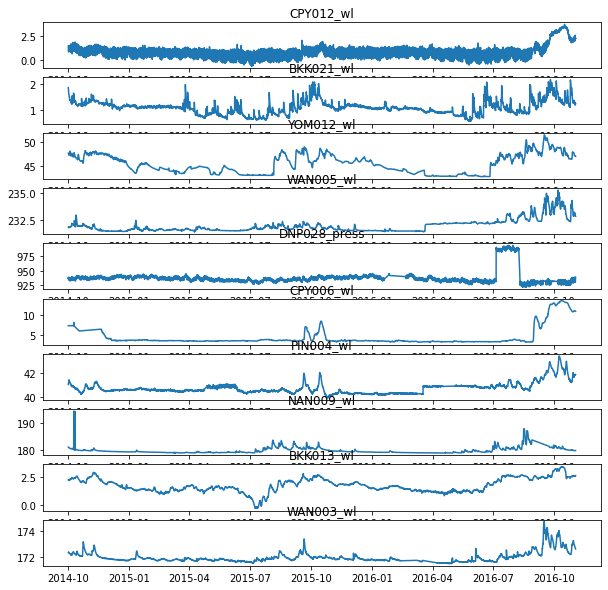

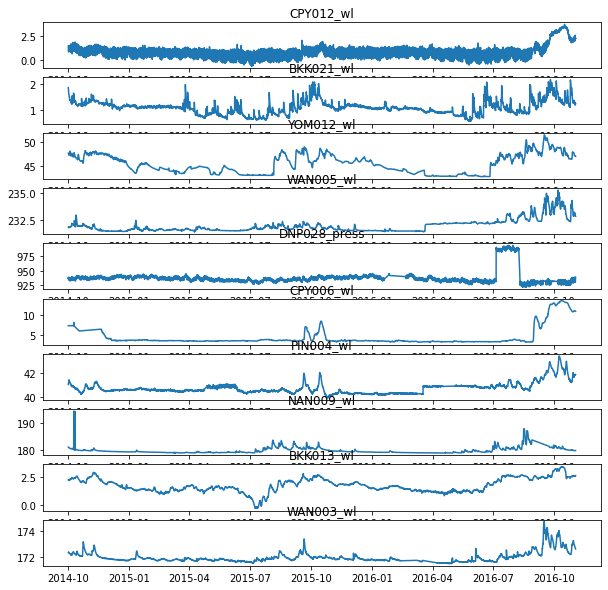

In [65]:
res.plot()

# Forecast

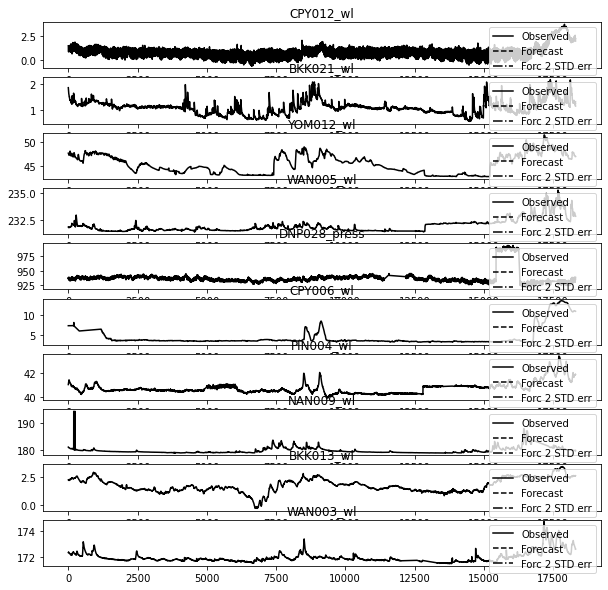

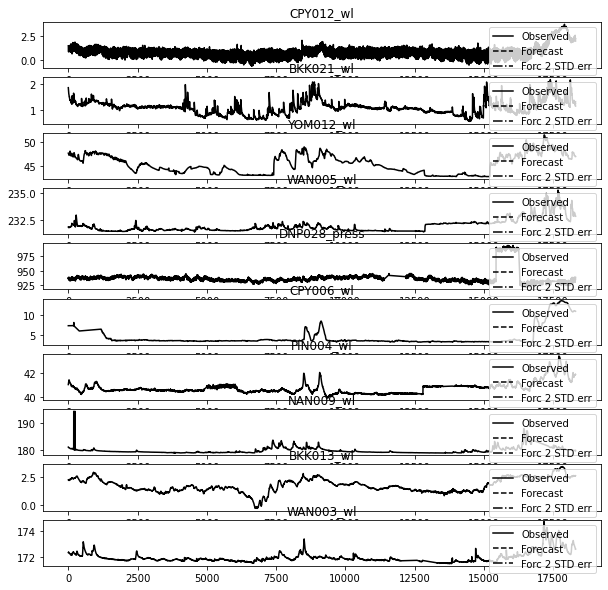

In [46]:
forecast_result = res.forecast(data_diff.values,72)
res.plot_forecast(4)

In [55]:
forecast_result[0,:]# result of target we want

array([-1.12156492, -0.12804134, -0.17324755,  0.30639934, 13.51562646,
       -0.25910732, -0.4524264 , -1.51313951, -0.07897089,  0.49476862])

In [53]:
pd.DataFrame(forecast_result,columns=['f-{}'.format(i) for i in data_mar.columns])

,f-CPY012_wl,f-BKK021_wl,f-YOM012_wl,f-WAN005_wl,f-DNP028_press,f-CPY006_wl,f-PIN004_wl,f-NAN009_wl,f-BKK013_wl,f-WAN003_wl
0,-1.121565,-0.128041,-0.173248,0.306399,13.515626,-0.259107,-0.452426,-1.513140,-0.078971,0.494769
1,-2.203497,-0.297998,-0.505198,0.717458,23.371458,-0.624464,-0.929025,-2.712407,-0.163023,1.219783
2,-3.260148,-0.504295,-0.946664,1.283918,34.565435,-1.128664,-1.444717,-3.658297,-0.268846,2.037525
3,-4.158634,-0.713621,-1.470074,1.975522,45.744779,-1.774139,-1.984146,-4.875203,-0.389683,2.921311
4,-5.009046,-0.929467,-2.047869,2.764706,55.616207,-2.516125,-2.567773,-6.007022,-0.520004,3.850337
...,...,...,...,...,...,...,...,...,...,...
67,-31.352518,-8.290736,-22.137447,61.351535,495.809813,-116.576835,-43.003390,-5.788010,-15.027237,73.841338
68,-31.515267,-8.334939,-21.941025,62.144616,499.149731,-118.818673,-43.448630,-5.389761,-15.237717,74.759932
69,-31.692551,-8.378610,-21.739874,62.928175,502.536936,-121.053522,-43.890039,-4.996110,-15.445554,75.671911
70,-31.877518,-8.421559,-21.531934,63.707589,506.439450,-123.282786,-44.335847,-4.552329,-15.647533,76.576216


In [ ]:
history = [x for x in train]
predict=list()

for t in tqdm(range(len(test))):
    history = pd.concat([train,test.iloc[:t,:]])
    
    mod = VAR(history)
    result = mod.fit(maxlags=15,ic='aic')
    
    
    yhat = result.forecast(history.values,72)
    predict.append(yhat[:,0])
    
    #testPredict = pd.concat([testPredict,pd.Series(yhat,index=idx[t:t+72])],axis=1)
    #Ytest=pd.concat([Ytest,pd.Series(save,index=idx[t:t+72])])

  0%|          | 1/8040 [00:00<1:28:08,  1.52it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  0%|          | 2/8040 [00:01<1:28:43,  1.51it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/

  0%|          | 15/8040 [00:09<1:26:25,  1.55it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  0%|          | 16/8040 [00:10<1:27:01,  1.54it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.

  0%|          | 29/8040 [00:18<1:26:52,  1.54it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  0%|          | 30/8040 [00:19<1:26:51,  1.54it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.

  1%|          | 43/8040 [00:28<1:27:52,  1.52it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  1%|          | 44/8040 [00:28<1:28:07,  1.51it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.

  1%|          | 57/8040 [00:37<1:30:43,  1.47it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  1%|          | 58/8040 [00:38<1:33:25,  1.42it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.

  1%|          | 71/8040 [00:48<1:50:10,  1.21it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  1%|          | 72/8040 [00:49<1:54:13,  1.16it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.

  1%|          | 85/8040 [01:01<2:00:18,  1.10it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  1%|          | 86/8040 [01:02<2:01:31,  1.09it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.

  1%|          | 99/8040 [01:14<2:05:55,  1.05it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  1%|          | 100/8040 [01:15<2:05:49,  1.05it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3

  1%|▏         | 113/8040 [01:27<2:07:10,  1.04it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  1%|▏         | 114/8040 [01:28<2:07:24,  1.04it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  2%|▏         | 127/8040 [01:41<2:06:58,  1.04it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  2%|▏         | 128/8040 [01:42<2:06:51,  1.04it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  2%|▏         | 141/8040 [01:54<2:07:50,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  2%|▏         | 142/8040 [01:55<2:07:33,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  2%|▏         | 155/8040 [02:08<2:07:31,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  2%|▏         | 156/8040 [02:09<2:07:25,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  2%|▏         | 169/8040 [02:22<2:06:42,  1.04it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  2%|▏         | 170/8040 [02:23<2:06:27,  1.04it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  2%|▏         | 183/8040 [02:35<2:06:40,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  2%|▏         | 184/8040 [02:36<2:07:38,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  2%|▏         | 197/8040 [02:49<2:07:18,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  2%|▏         | 198/8040 [02:50<2:07:50,  1.02it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  3%|▎         | 211/8040 [03:03<2:07:14,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  3%|▎         | 212/8040 [03:04<2:07:04,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  3%|▎         | 225/8040 [03:16<2:08:33,  1.01it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  3%|▎         | 226/8040 [03:17<2:08:18,  1.01it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  3%|▎         | 239/8040 [03:30<2:07:11,  1.02it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  3%|▎         | 240/8040 [03:31<2:07:04,  1.02it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  3%|▎         | 253/8040 [03:44<2:05:03,  1.04it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  3%|▎         | 254/8040 [03:44<2:05:02,  1.04it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  3%|▎         | 267/8040 [03:57<2:05:32,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  3%|▎         | 268/8040 [03:58<2:05:13,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  3%|▎         | 281/8040 [04:10<2:01:38,  1.06it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  4%|▎         | 282/8040 [04:11<2:01:28,  1.06it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  4%|▎         | 295/8040 [04:21<1:36:59,  1.33it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  4%|▎         | 296/8040 [04:22<1:38:01,  1.32it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  4%|▍         | 309/8040 [04:34<2:00:47,  1.07it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  4%|▍         | 310/8040 [04:35<2:00:08,  1.07it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  4%|▍         | 323/8040 [04:45<1:52:35,  1.14it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  4%|▍         | 324/8040 [04:46<1:55:34,  1.11it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  4%|▍         | 337/8040 [04:58<2:01:35,  1.06it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  4%|▍         | 338/8040 [04:59<2:01:38,  1.06it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  4%|▍         | 351/8040 [05:12<2:01:08,  1.06it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  4%|▍         | 352/8040 [05:12<2:01:26,  1.06it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  5%|▍         | 365/8040 [05:25<2:00:54,  1.06it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  5%|▍         | 366/8040 [05:26<2:01:24,  1.05it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  5%|▍         | 379/8040 [05:37<1:37:57,  1.30it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  5%|▍         | 380/8040 [05:37<1:38:07,  1.30it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  5%|▍         | 393/8040 [05:48<1:58:58,  1.07it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  5%|▍         | 394/8040 [05:49<2:00:43,  1.06it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  5%|▌         | 407/8040 [06:02<2:04:33,  1.02it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  5%|▌         | 408/8040 [06:03<2:04:41,  1.02it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  5%|▌         | 421/8040 [06:15<1:46:47,  1.19it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  5%|▌         | 422/8040 [06:16<1:44:23,  1.22it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  5%|▌         | 435/8040 [06:25<1:29:42,  1.41it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  5%|▌         | 436/8040 [06:26<1:29:48,  1.41it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  6%|▌         | 449/8040 [06:35<1:28:32,  1.43it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  6%|▌         | 450/8040 [06:36<1:28:53,  1.42it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  6%|▌         | 463/8040 [06:45<1:27:34,  1.44it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  6%|▌         | 464/8040 [06:46<1:27:50,  1.44it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  6%|▌         | 477/8040 [06:55<1:27:33,  1.44it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  6%|▌         | 478/8040 [06:55<1:27:43,  1.44it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  6%|▌         | 491/8040 [07:04<1:28:34,  1.42it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  6%|▌         | 492/8040 [07:05<1:28:59,  1.41it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  6%|▋         | 505/8040 [07:14<1:28:58,  1.41it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  6%|▋         | 506/8040 [07:15<1:29:32,  1.40it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  6%|▋         | 519/8040 [07:27<2:01:58,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  6%|▋         | 520/8040 [07:28<2:01:59,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  7%|▋         | 533/8040 [07:40<2:01:38,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  7%|▋         | 534/8040 [07:41<2:01:44,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  7%|▋         | 547/8040 [07:54<2:01:24,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  7%|▋         | 548/8040 [07:55<2:02:00,  1.02it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  7%|▋         | 561/8040 [08:08<2:02:34,  1.02it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  7%|▋         | 562/8040 [08:09<2:02:40,  1.02it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  7%|▋         | 575/8040 [08:22<2:01:07,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  7%|▋         | 576/8040 [08:23<2:01:37,  1.02it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  7%|▋         | 589/8040 [08:35<2:00:33,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  7%|▋         | 590/8040 [08:36<2:01:05,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  8%|▊         | 603/8040 [08:49<2:01:26,  1.02it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  8%|▊         | 604/8040 [08:50<2:01:50,  1.02it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  8%|▊         | 617/8040 [09:03<2:01:10,  1.02it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  8%|▊         | 618/8040 [09:04<2:01:34,  1.02it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  8%|▊         | 631/8040 [09:16<2:02:16,  1.01it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  8%|▊         | 632/8040 [09:17<2:02:14,  1.01it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  8%|▊         | 645/8040 [09:30<2:03:22,  1.00s/it]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  8%|▊         | 646/8040 [09:31<2:03:18,  1.00s/it]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  8%|▊         | 659/8040 [09:44<2:02:06,  1.01it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  8%|▊         | 660/8040 [09:45<2:01:34,  1.01it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  8%|▊         | 673/8040 [09:58<2:05:48,  1.02s/it]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  8%|▊         | 674/8040 [09:59<2:05:50,  1.03s/it]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  9%|▊         | 687/8040 [10:13<2:05:31,  1.02s/it]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  9%|▊         | 688/8040 [10:14<2:06:12,  1.03s/it]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  9%|▊         | 701/8040 [10:27<2:07:12,  1.04s/it]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  9%|▊         | 702/8040 [10:28<2:07:19,  1.04s/it]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  9%|▉         | 715/8040 [10:42<2:03:06,  1.01s/it]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  9%|▉         | 716/8040 [10:43<2:03:08,  1.01s/it]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  9%|▉         | 729/8040 [10:55<1:58:15,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  9%|▉         | 730/8040 [10:56<1:53:12,  1.08it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  9%|▉         | 743/8040 [11:06<1:34:07,  1.29it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  9%|▉         | 744/8040 [11:07<1:34:22,  1.29it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

  9%|▉         | 757/8040 [11:17<1:35:12,  1.27it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
  9%|▉         | 758/8040 [11:18<1:35:15,  1.27it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

 10%|▉         | 771/8040 [11:29<1:40:41,  1.20it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
 10%|▉         | 772/8040 [11:29<1:38:12,  1.23it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

 10%|▉         | 785/8040 [11:41<1:57:44,  1.03it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
 10%|▉         | 786/8040 [11:41<1:54:23,  1.06it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

 10%|▉         | 799/8040 [11:52<1:34:42,  1.27it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
 10%|▉         | 800/8040 [11:52<1:34:21,  1.28it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

 10%|█         | 813/8040 [12:02<1:34:19,  1.28it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
 10%|█         | 814/8040 [12:03<1:34:52,  1.27it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

 10%|█         | 827/8040 [12:13<1:33:58,  1.28it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
 10%|█         | 828/8040 [12:14<1:33:57,  1.28it/s]/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python

In [83]:
pd.DataFrame(predict)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,2.226261,2.132533,2.125481,2.109166,2.111775,2.122134,2.163221,2.222767,2.279142,2.324214,...,2.197751,2.189965,2.184956,2.183538,2.185565,2.189982,2.195070,2.199011,2.200543,2.199200
1,2.120509,2.079951,2.026731,2.009704,2.044793,2.113594,2.166296,2.228890,2.266537,2.284745,...,2.392753,2.387249,2.385301,2.386978,2.391641,2.397883,2.403800,2.407644,2.408380,2.405900
2,2.203774,2.188188,2.199222,2.239288,2.281612,2.292348,2.334818,2.339679,2.333260,2.331871,...,2.312445,2.312249,2.314758,2.319007,2.323505,2.326762,2.327762,2.326207,2.322479,2.317475
3,2.110391,2.109626,2.151257,2.198362,2.215685,2.269427,2.287137,2.300666,2.318810,2.296128,...,2.259351,2.261540,2.265886,2.270949,2.275132,2.277099,2.276230,2.272762,2.267615,2.262029
4,2.099613,2.144091,2.193644,2.213152,2.262040,2.280989,2.297433,2.316230,2.297104,2.271815,...,2.235686,2.239801,2.244447,2.248111,2.249542,2.248163,2.244255,2.238803,2.233081,2.228278
5,2.075288,2.108382,2.119945,2.169426,2.196561,2.230588,2.272824,2.278691,2.275005,2.267837,...,2.218414,2.222257,2.226502,2.229728,2.230848,2.229396,2.225675,2.220565,2.215195,2.210628
6,2.025232,2.020022,2.061486,2.092157,2.138198,2.201140,2.235794,2.260897,2.277113,2.281200,...,2.217742,2.220987,2.224397,2.226834,2.227461,2.225931,2.222481,2.217839,2.212964,2.208802
7,1.966689,1.998668,2.030127,2.078601,2.148853,2.192565,2.231234,2.263522,2.280814,2.280369,...,2.210021,2.213276,2.215958,2.217233,2.216638,2.214155,2.210250,2.205743,2.201581,2.198604
8,2.044008,2.086163,2.135830,2.204780,2.241154,2.269801,2.289070,2.289737,2.276077,2.261171,...,2.211413,2.214487,2.215658,2.214472,2.211062,2.206179,2.200919,2.196396,2.193483,2.192565
9,2.137838,2.177378,2.233325,2.257281,2.284270,2.299087,2.296022,2.282283,2.264533,2.244401,...,2.196775,2.198476,2.199832,2.200168,2.199169,2.197025,2.194256,2.191446,2.189056,2.187382


# SVR

In [4]:
def to_supervise(data,target,n_out):
    data[target]=data[target].shift(-n_out)
    data = data.astype('float64').dropna()
    X = data.drop([target],axis=1)
    xlabels = list(X.columns)
    X = X
    y = data[target]
    return X,y,xlabels

In [5]:
loading = instant_data()
df,mode = loading.hourly_instant(),'hour'
#df,mode = loading.daily_instant(),'day'

if mode =='hour': n_past,n_future = 24*7,24
elif mode =='day': n_past,n_future = 30,14
else: n_future=None; print('incorrect input')

st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)
#-----------------------------#
save_path =host_path+'/Trial/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [6]:
start_p = '2016-01-01'
stop_p ='2017-01-01'
#split_date = '2015-05-01'


data = df[start_p:stop_p]
split_date = int(len(data)*.7)
data = data.interpolate(limit=3000000000,limit_direction='both').astype('float32')
data['Day'] = data.index.dayofyear #add day

In [7]:
cutoff=.3
data_mar = call_mar(data,target,mode,cutoff=cutoff)
data_mar = move_column_inplace(data_mar,target,0)
n_features = len(data_mar.columns)

In [8]:
from sklearn.preprocessing import StandardScaler
#from  sklearn.model_selection import train_test_split


#----------

<ipython-input-4-5025259961bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target]=data[target].shift(-n_out)


In [20]:
kernals = ['Polynomial', 'RBF','Linear']#A function which returns the corresponding SVC model
def getClassifier(ktype):
    if ktype == 0:
        # Polynomial kernal
        return svm.SVR(kernel='poly', degree=8, gamma="auto")
    elif ktype == 1:
        # Radial Basis Function kernal
        return svm.SVR(kernel='rbf', gamma="auto")
    elif ktype == 2:
        # Linear kernal
        return svm.SVR(kernel='linear', gamma="auto")

In [ ]:
for i in range(3):
    svr = getClassifier(i)
    steps = [('scale',StandardScaler()), ('svr', svr)]
    pipe = Pipeline(steps=steps)

    pipe.fit(trainX, trainY)
    #trainPredict = pipe.predict(trainX)
    testPredict = pipe.predict(testX)
    
    mse,nse,r2,rmse,mae = real_eva_error(testY,testPredict)
    plt.title("Evalu:"+kernals[i]+ "kernel"+ '\nMSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse,nse,r2))
    plt.plot(testY.values,label="true")
    plt.plot(testPredict,'--',label=kernals[i])
    plt.legend()
    plt.show()

# Tuing hyperparameter


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor 

In [18]:
scaler=StandardScaler()
trainX = scaler.fit_transform(trainX)
testX = scaler.transform(testX)

In [ ]:
#param_grid = {'C': [1e-6,1e-5,1e-4,1e-3,1e-2,0.1,1,10,10**2,10**3,10**4,10**5,10**6], 'gamma': [1e-6,1e-5,1e-4,1e-3,1e-2,0.1,1,10,10**2,10**3,10**4,10**5,10**6],'kernel': ['rbf', 'linear']}
param_grid = {'C': [1e-6,1e-5,1e-4,1e-3,1e-2,0.1,1,10,10**2,10**3,10**4], 'gamma': [1e-6,1e-5,1e-4,1e-3,1e-2,0.1,1,10,10**2,10**3,10**4,10**5,10**6],'kernel': ['rbf', 'linear']}
grid = GridSearchCV(svm.SVR(),param_grid,refit=True,verbose=2)
grid.fit(trainX,trainY)

Fitting 5 folds for each of 286 candidates, totalling 1430 fits
[CV] C=1e-06, gamma=1e-06, kernel=rbf ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. C=1e-06, gamma=1e-06, kernel=rbf, total=   0.8s
[CV] C=1e-06, gamma=1e-06, kernel=rbf ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ................. C=1e-06, gamma=1e-06, kernel=rbf, total=   1.0s
[CV] C=1e-06, gamma=1e-06, kernel=rbf ................................
[CV] ................. C=1e-06, gamma=1e-06, kernel=rbf, total=   0.9s
[CV] C=1e-06, gamma=1e-06, kernel=rbf ................................
[CV] ................. C=1e-06, gamma=1e-06, kernel=rbf, total=   0.8s
[CV] C=1e-06, gamma=1e-06, kernel=rbf ................................
[CV] ................. C=1e-06, gamma=1e-06, kernel=rbf, total=   1.0s
[CV] C=1e-06, gamma=1e-06, kernel=linear .............................
[CV] .............. C=1e-06, gamma=1e-06, kernel=linear, total=   0.4s
[CV] C=1e-06, gamma=1e-06, kernel=linear .............................
[CV] .............. C=1e-06, gamma=1e-06, kernel=linear, total=   0.4s
[CV] C=1e-06, gamma=1e-06, kernel=linear .............................
[CV] .............. C=1e-06, gamma=1e-06, kernel=linear, total=   0.4s
[CV] C=1e-06, gamma=1e-06, kernel=linear .............................
[CV] .

[CV] ................ C=1e-06, gamma=0.1, kernel=linear, total=   0.4s
[CV] C=1e-06, gamma=1, kernel=rbf ....................................
[CV] ..................... C=1e-06, gamma=1, kernel=rbf, total=   1.1s
[CV] C=1e-06, gamma=1, kernel=rbf ....................................
[CV] ..................... C=1e-06, gamma=1, kernel=rbf, total=   1.0s
[CV] C=1e-06, gamma=1, kernel=rbf ....................................
[CV] ..................... C=1e-06, gamma=1, kernel=rbf, total=   1.0s
[CV] C=1e-06, gamma=1, kernel=rbf ....................................
[CV] ..................... C=1e-06, gamma=1, kernel=rbf, total=   1.0s
[CV] C=1e-06, gamma=1, kernel=rbf ....................................
[CV] ..................... C=1e-06, gamma=1, kernel=rbf, total=   0.9s
[CV] C=1e-06, gamma=1, kernel=linear .................................
[CV] .................. C=1e-06, gamma=1, kernel=linear, total=   0.4s
[CV] C=1e-06, gamma=1, kernel=linear .................................
[CV] .

[CV] ............. C=1e-06, gamma=100000, kernel=linear, total=   0.4s
[CV] C=1e-06, gamma=100000, kernel=linear ............................
[CV] ............. C=1e-06, gamma=100000, kernel=linear, total=   0.4s
[CV] C=1e-06, gamma=100000, kernel=linear ............................
[CV] ............. C=1e-06, gamma=100000, kernel=linear, total=   0.4s
[CV] C=1e-06, gamma=1000000, kernel=rbf ..............................
[CV] ............... C=1e-06, gamma=1000000, kernel=rbf, total=   0.6s
[CV] C=1e-06, gamma=1000000, kernel=rbf ..............................
[CV] ............... C=1e-06, gamma=1000000, kernel=rbf, total=   0.6s
[CV] C=1e-06, gamma=1000000, kernel=rbf ..............................
[CV] ............... C=1e-06, gamma=1000000, kernel=rbf, total=   0.6s
[CV] C=1e-06, gamma=1000000, kernel=rbf ..............................
[CV] ............... C=1e-06, gamma=1000000, kernel=rbf, total=   0.6s
[CV] C=1e-06, gamma=1000000, kernel=rbf ..............................
[CV] .

[CV] ............... C=1e-05, gamma=0.01, kernel=linear, total=   0.4s
[CV] C=1e-05, gamma=0.01, kernel=linear ..............................
[CV] ............... C=1e-05, gamma=0.01, kernel=linear, total=   0.4s
[CV] C=1e-05, gamma=0.01, kernel=linear ..............................
[CV] ............... C=1e-05, gamma=0.01, kernel=linear, total=   0.4s
[CV] C=1e-05, gamma=0.01, kernel=linear ..............................
[CV] ............... C=1e-05, gamma=0.01, kernel=linear, total=   0.4s
[CV] C=1e-05, gamma=0.01, kernel=linear ..............................
[CV] ............... C=1e-05, gamma=0.01, kernel=linear, total=   0.4s
[CV] C=1e-05, gamma=0.1, kernel=rbf ..................................
[CV] ................... C=1e-05, gamma=0.1, kernel=rbf, total=   0.8s
[CV] C=1e-05, gamma=0.1, kernel=rbf ..................................
[CV] ................... C=1e-05, gamma=0.1, kernel=rbf, total=   0.8s
[CV] C=1e-05, gamma=0.1, kernel=rbf ..................................
[CV] .

[CV] ................. C=1e-05, gamma=10000, kernel=rbf, total=   0.6s
[CV] C=1e-05, gamma=10000, kernel=rbf ................................
[CV] ................. C=1e-05, gamma=10000, kernel=rbf, total=   0.6s
[CV] C=1e-05, gamma=10000, kernel=linear .............................
[CV] .............. C=1e-05, gamma=10000, kernel=linear, total=   0.4s
[CV] C=1e-05, gamma=10000, kernel=linear .............................
[CV] .............. C=1e-05, gamma=10000, kernel=linear, total=   0.4s
[CV] C=1e-05, gamma=10000, kernel=linear .............................
[CV] .............. C=1e-05, gamma=10000, kernel=linear, total=   0.4s
[CV] C=1e-05, gamma=10000, kernel=linear .............................
[CV] .............. C=1e-05, gamma=10000, kernel=linear, total=   0.4s
[CV] C=1e-05, gamma=10000, kernel=linear .............................
[CV] .............. C=1e-05, gamma=10000, kernel=linear, total=   0.4s
[CV] C=1e-05, gamma=100000, kernel=rbf ...............................
[CV] .

[CV] ................ C=0.0001, gamma=0.001, kernel=rbf, total=   0.8s
[CV] C=0.0001, gamma=0.001, kernel=rbf ...............................
[CV] ................ C=0.0001, gamma=0.001, kernel=rbf, total=   0.8s
[CV] C=0.0001, gamma=0.001, kernel=rbf ...............................
[CV] ................ C=0.0001, gamma=0.001, kernel=rbf, total=   0.8s
[CV] C=0.0001, gamma=0.001, kernel=rbf ...............................
[CV] ................ C=0.0001, gamma=0.001, kernel=rbf, total=   0.8s
[CV] C=0.0001, gamma=0.001, kernel=linear ............................
[CV] ............. C=0.0001, gamma=0.001, kernel=linear, total=   0.4s
[CV] C=0.0001, gamma=0.001, kernel=linear ............................
[CV] ............. C=0.0001, gamma=0.001, kernel=linear, total=   0.4s
[CV] C=0.0001, gamma=0.001, kernel=linear ............................
[CV] ............. C=0.0001, gamma=0.001, kernel=linear, total=   0.4s
[CV] C=0.0001, gamma=0.001, kernel=linear ............................
[CV] .

[CV] ............... C=0.0001, gamma=100, kernel=linear, total=   0.5s
[CV] C=0.0001, gamma=1000, kernel=rbf ................................
[CV] ................. C=0.0001, gamma=1000, kernel=rbf, total=   0.6s
[CV] C=0.0001, gamma=1000, kernel=rbf ................................
[CV] ................. C=0.0001, gamma=1000, kernel=rbf, total=   0.7s
[CV] C=0.0001, gamma=1000, kernel=rbf ................................
[CV] ................. C=0.0001, gamma=1000, kernel=rbf, total=   0.6s
[CV] C=0.0001, gamma=1000, kernel=rbf ................................
[CV] ................. C=0.0001, gamma=1000, kernel=rbf, total=   0.7s
[CV] C=0.0001, gamma=1000, kernel=rbf ................................
[CV] ................. C=0.0001, gamma=1000, kernel=rbf, total=   0.6s
[CV] C=0.0001, gamma=1000, kernel=linear .............................
[CV] .............. C=0.0001, gamma=1000, kernel=linear, total=   0.5s
[CV] C=0.0001, gamma=1000, kernel=linear .............................
[CV] .

[CV] .............. C=0.001, gamma=1e-05, kernel=linear, total=   0.5s
[CV] C=0.001, gamma=1e-05, kernel=linear .............................
[CV] .............. C=0.001, gamma=1e-05, kernel=linear, total=   0.5s
[CV] C=0.001, gamma=1e-05, kernel=linear .............................
[CV] .............. C=0.001, gamma=1e-05, kernel=linear, total=   0.5s
[CV] C=0.001, gamma=0.0001, kernel=rbf ...............................
[CV] ................ C=0.001, gamma=0.0001, kernel=rbf, total=   0.8s
[CV] C=0.001, gamma=0.0001, kernel=rbf ...............................
[CV] ................ C=0.001, gamma=0.0001, kernel=rbf, total=   0.8s
[CV] C=0.001, gamma=0.0001, kernel=rbf ...............................
[CV] ................ C=0.001, gamma=0.0001, kernel=rbf, total=   0.8s
[CV] C=0.001, gamma=0.0001, kernel=rbf ...............................
[CV] ................ C=0.001, gamma=0.0001, kernel=rbf, total=   0.8s
[CV] C=0.001, gamma=0.0001, kernel=rbf ...............................
[CV] .

[CV] ................. C=0.001, gamma=10, kernel=linear, total=   0.5s
[CV] C=0.001, gamma=10, kernel=linear ................................
[CV] ................. C=0.001, gamma=10, kernel=linear, total=   0.5s
[CV] C=0.001, gamma=10, kernel=linear ................................
[CV] ................. C=0.001, gamma=10, kernel=linear, total=   0.5s
[CV] C=0.001, gamma=10, kernel=linear ................................
[CV] ................. C=0.001, gamma=10, kernel=linear, total=   0.5s
[CV] C=0.001, gamma=10, kernel=linear ................................
[CV] ................. C=0.001, gamma=10, kernel=linear, total=   0.5s
[CV] C=0.001, gamma=100, kernel=rbf ..................................
[CV] ................... C=0.001, gamma=100, kernel=rbf, total=   0.7s
[CV] C=0.001, gamma=100, kernel=rbf ..................................
[CV] ................... C=0.001, gamma=100, kernel=rbf, total=   0.7s
[CV] C=0.001, gamma=100, kernel=rbf ..................................
[CV] .

[CV] .................. C=0.01, gamma=1e-06, kernel=rbf, total=   0.8s
[CV] C=0.01, gamma=1e-06, kernel=rbf .................................
[CV] .................. C=0.01, gamma=1e-06, kernel=rbf, total=   0.8s
[CV] C=0.01, gamma=1e-06, kernel=linear ..............................


In [ ]:
print(grid.best_estimator_)

In [43]:
#grid_predictions = grid.predict(X_test)

In [ ]:
#plt.plot(sc_y.inverse_transform(grid_predictions))
#plt.plot(sc_y.inverse_transform(testY))

In [13]:
param_grid_2 = {'n_estimators': [10,100,200,300,400,500,600,700,800,900,1000]}
grid_2 = GridSearchCV(RandomForestRegressor(),param_grid_2,refit=True,verbose=2)
grid_2.fit(trainX,trainY)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.2s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .................................. n_estimators=10, total=   0.2s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.2s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.2s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.2s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   1.8s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   1.9s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   1.8s
[CV] n_estimators=100 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  8.8min finished


GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [10, 100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1000]},
             verbose=2)

In [14]:
print(grid_2.best_estimator_)

RandomForestRegressor(n_estimators=600)


# Evaluation

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
record_result(trainY,testY,trainPredict,testPredict,'SVR_trial')

Plot

In [18]:
# plt.figure(figsize=(20,5))
# plt.plot(trainY.sort_index(),'.',label="Train_Actual")
# plt.plot(trainPredict.sort_index(),'.',label="Train_Predict")
# plt.plot(testY.sort_index(),'x',label="Test_Actual")
# plt.plot(testPredict.sort_index(),'x',label="Test_Predict")
# plt.title('[Multi Linear Regression *Testonly]\nWater Level CPY015 Forecast vs Actuals\n'+'Train MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse,nse,r2)+'\nTest  MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (Tmse,Tnse,Tr2))

# plt.legend()
# plt.show()
# #plt.savefig('output/Linear/result_Linear.png', dpi=300, bbox_inches='tight')

# VAR model

In [21]:
# VAR example
from statsmodels.tsa.vector_ar.var_model import VAR

https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [26]:
# from statsmodels.tsa.stattools import grangercausalitytests
# maxlag=12
# test = 'ssr_chi2test'
# def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
#     """Check Granger Causality of all possible combinations of the Time series.
#     The rows are the response variable, columns are predictors. The values in the table 
#     are the P-Values. P-Values lesser than the significance level (0.05), implies 
#     the Null Hypothesis that the coefficients of the corresponding past values is 
#     zero, that is, the X does not cause Y can be rejected.

#     data      : pandas dataframe containing the time series variables
#     variables : list containing names of the time series variables.
#     """
#     df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
#     for c in df.columns:
#         for r in df.index:
#             test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
#             p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
#             if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
#             min_p_value = np.min(p_values)
#             df.loc[r, c] = min_p_value
#     df.columns = [var + '_x' for var in variables]
#     df.index = [var + '_y' for var in variables]
#     return df

# grangers_causation_matrix(data, variables = data.columns)        

In [22]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(data)

/home/song/anaconda3/envs/tf/lib/python3.8/site-packages/statsmodels/tsa/vector_ar/vecm.py:569: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  warnings.warn("Critical values are only available for time series "
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
DNP028_press ::  92610.75  > nan       =>   False
GLF001_wl ::  81100.49  > nan       =>   False
DNP006_humid ::  73269.35  > nan       =>   False
DNP002_temp ::  67007.75  > nan       =>   False
DNP032_temp ::  60871.01  > nan       =>   False
DNP002_humid ::  54857.68  > nan       =>   False
DNP007_temp ::  49216.66  > nan       =>   False
DNP008_temp ::  44046.14  > nan       =>   False
CPY015_rain1h ::  38901.69  > nan       =>   False
DNP033_rain1h ::  33999.06  > nan       =>   False
PAS005_wl ::  29306.31  > nan       =>   False
DNP010_humid ::  24901.66  > nan       =>   False
CPY009_temp ::  20891.21  > nan       =>   False
YOM

In [23]:
nobs = 4
train, test = data[0:-nobs], data[-nobs:]

In [24]:
model = VAR(train)
model_fit = model.fit()

In [25]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,41.94,41.95,1.644e+18,41.95
1,-8.753,-8.591,0.0001581,-8.702
2,-12.78,-12.46,2.825e-06,-12.68
3,-13.19,-12.71,1.875e-06,-13.04
4,-13.37,-12.74,1.557e-06,-13.17
5,-13.56,-12.77,1.291e-06,-13.31
6,-13.80,-12.85*,1.020e-06,-13.50
7,-13.95,-12.85,8.772e-07,-13.60
8,-14.09,-12.84,7.603e-07,-13.69
9,-14.24,-12.83,6.568e-07,-13.79


In [26]:
model_fitted = model.fit(4)
model_fitted.summary()

7.360           0.000
L1.DNP032_temp           0.000418         0.000510            0.819           0.413
L1.DNP002_humid         -0.000231         0.000126           -1.835           0.067
L1.DNP007_temp          -0.002361         0.000467           -5.054           0.000
L1.DNP008_temp          -0.001957         0.000540           -3.623           0.000
L1.CPY015_rain1h         0.000541         0.000511            1.060           0.289
L1.DNP033_rain1h         0.001741         0.000556            3.133           0.002
L1.PAS005_wl            -0.002977         0.001878           -1.585           0.113
L1.DNP010_humid         -0.000112         0.000100           -1.127           0.260
L1.CPY009_temp           0.000824         0.000220            3.742           0.000
L1.YOM009_wl             0.000124         0.003601            0.035           0.972
L1.DNP027_temp          -0.000465         0.000270           -1.724           0.085
L1.CPY013_wl             0.045144         0.005018    

In [27]:
lag_order = model_fitted.k_ar   
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = test.values[-lag_order:]
forecast_input

4


array([[ 9.35630000e+02,  1.56000000e+00,  8.98300000e+01,
         2.20500000e+01,  2.15600000e+01,  6.51700000e+01,
         2.30300000e+01,  1.91100000e+01,  0.00000000e+00,
         0.00000000e+00,  4.22200000e+01,  8.71700000e+01,
         3.18500000e+01,  2.68833333e+01,  2.20500000e+01,
         9.80000000e-01,  1.97355000e+02,  0.00000000e+00,
         1.81300000e+01,  7.53646592e+01,  7.75000000e+01,
         4.13300000e+01,  2.64600000e+01,  1.19166667e+02,
         1.40308622e+02,  1.96000000e+01,  1.20166667e+00,
        -3.83333333e-02],
       [ 9.36710000e+02,  1.26833333e+00,  9.48300000e+01,
         2.15600000e+01,  2.05800000e+01,  6.36700000e+01,
         2.20500000e+01,  1.86200000e+01,  0.00000000e+00,
         0.00000000e+00,  4.22200000e+01,  9.11700000e+01,
         3.28300000e+01,  2.68900000e+01,  2.15600000e+01,
         9.98333333e-01,  1.97360000e+02,  0.00000000e+00,
         1.76400000e+01,  7.53646592e+01,  8.15000000e+01,
         4.13300000e+01,  2.40

In [28]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=data.index[-nobs:], columns=data.columns + '_2d')
df_forecast

,DNP028_press_2d,GLF001_wl_2d,DNP006_humid_2d,DNP002_temp_2d,DNP032_temp_2d,DNP002_humid_2d,DNP007_temp_2d,DNP008_temp_2d,CPY015_rain1h_2d,DNP033_rain1h_2d,...,DNP033_temp_2d,DNP004_humid_2d,DNP007_humid_2d,NAN013_wl_2d,DNP025_temp_2d,PIN001_wl_2d,PAS001_wl_2d,DNP006_temp_2d,CPY012_wl_2d,CPY015_wl_2d
date,,,,,,,,,,,,,,,,,,,,,
2017-12-24 20:00:00,937.139697,0.300645,77.782017,19.068220,18.891805,72.040407,19.944447,16.859891,0.037525,-0.072343,...,17.282835,77.222369,88.206055,41.345033,21.755237,119.702681,140.297733,17.042952,1.293316,-0.351309
2017-12-24 21:00:00,936.980625,0.161930,78.426435,19.019191,18.692422,72.930838,19.449394,16.815759,-0.025087,-0.088847,...,17.542529,77.902245,89.115523,41.352572,21.029310,119.716061,140.293180,16.655664,1.234357,-0.107219
2017-12-24 22:00:00,936.610898,0.164726,77.649327,19.392180,18.891676,73.027530,19.086428,17.149344,-0.055256,-0.045454,...,18.104482,77.974661,89.313011,41.365973,20.860856,119.684872,140.283993,16.604989,1.158262,0.194701
2017-12-24 23:00:00,936.475450,0.298226,76.953467,20.058622,19.609979,72.049985,19.289789,17.698210,-0.070798,-0.041615,...,18.737152,77.712905,88.410086,41.370315,21.155439,119.624950,140.272485,17.025242,1.073779,0.499808
